In [1]:
import random
#from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import random
import os
import numpy as np
import tqdm
import time

# SEED = 0
# random.seed(SEED)
# np.random.seed(SEED)
# #tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-09-04 13:33:40.353291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 13:33:40.972287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-04 13:33:41.700172: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-04 13:33:41.740970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
#CBAM Block

from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU, Dense,Conv2DTranspose,Conv2D,MaxPooling2D,BatchNormalization,add,AveragePooling2D
from tensorflow.keras.layers import Layer,concatenate,GlobalMaxPooling2D,GlobalAveragePooling2D,Lambda,Permute,Reshape,Dense,Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K


@tf.keras.utils.register_keras_serializable(package="MyLayers")
class CBAM(Layer):
    def __init__(self, ratio=8, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.channel = input_shape[1]
        self.shared_layer_one = Dense(self.channel // self.ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')
        self.shared_layer_two = Dense(self.channel,
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')
        self.conv_layer = Conv2D(filters=1, kernel_size=self.kernel_size, strides=1, padding='same',
                                 activation='sigmoid', kernel_initializer='he_normal',
                                 use_bias=False, data_format='channels_first')
        super(CBAM, self).build(input_shape)

    def call(self, inputs):
        avg_pool = GlobalAveragePooling2D(data_format='channels_first')(inputs)
        avg_pool = Reshape((1, 1, self.channel))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = GlobalMaxPooling2D(data_format='channels_first')(inputs)
        max_pool = Reshape((1, 1, self.channel))(max_pool)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        cbam_channel = add([avg_pool, max_pool])
        cbam_channel = Activation('sigmoid')(cbam_channel)
        cbam_channel = Permute((3, 1, 2))(cbam_channel)

        avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(inputs)
        max_pool = Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=True))(inputs)
        concat = concatenate([avg_pool, max_pool], axis=1)

        cbam_spatial = self.conv_layer(concat)

        cbam_feature = tf.multiply(inputs, cbam_channel)
        cbam_feature = tf.multiply(cbam_feature, cbam_spatial)

        return cbam_feature

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({'ratio': self.ratio, 'kernel_size': self.kernel_size})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [3]:
from tensorflow.keras.models import load_model
# # load model
model = load_model(f"/home/availab-dl1/Sandboxes/Mohammad/DownscalingModel.keras",custom_objects={"CBAM": CBAM}) 


2024-09-04 13:33:43.229730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-04 13:33:43.229960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-04 13:33:43.230129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
#SR_estimated_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"
SR_estimated_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/5by5"
Input_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"
Target_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"


#NOW LETS LOAD THE train DATASET progressively

batch_size=10
n_test=3570
start=0


def test_data_generator(batch_size=batch_size, start_array=start, n_target=n_test, high_altitude_directory=SR_estimated_directory, 
                            Target_directory=Target_directory,Input_directory=Input_directory):

     
        if high_altitude_directory == f"/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres":
            for i in range(start_array, n_target, batch_size):

                input_batch = np.array([np.load(f"{Input_directory}/X_test/%d.npy" % j) for j in range(i, i+batch_size)])  # Low-res images for input
                input_batch[:, 3] = input_batch[:, 3] / 4  # Normalising T40
                input_batch[:, 4] = input_batch[:, 4] / 1500
                input_batch[:, 5] = input_batch[:, 5] / 90
                input_batch[:, 6] = input_batch[:, 6] / 2


                target_batch = np.array([np.load(f"{Target_directory}/Y_test/%d.npy" % j) for j in range(i, i+batch_size)])  # High-res images as target


                yield input_batch, target_batch 
        else:
            for i in range(start_array, n_target, batch_size):

                reconstructed_batch = np.array([np.load(f"{high_altitude_directory}/X_test/%d.npy" % j) for j in range(i, i+batch_size)])
                reconstructed_batch=np.reshape(reconstructed_batch,[batch_size,4,416,416])  ##loading reconstructed data from SR step
                reconstructed_batch[:, 3] = reconstructed_batch[:, 3] / 4  # Normalising T40
                #print(reconstructed_batch.shape)

                terrain_batch = np.array([np.load(f"{Input_directory}/X_test/%d.npy" % j) for j in range(i, i+batch_size)])[:,4:8]   ##loading high res terrain., vegetation and fire data
                terrain_batch[:, 0] = terrain_batch[:, 0] / 1500
                terrain_batch[:, 1] = terrain_batch[:, 1] / 90
                terrain_batch[:, 2] = terrain_batch[:, 2] / 2
                input_batch=np.concatenate((reconstructed_batch,terrain_batch),axis=1)
                
                target_batch = np.array([np.load(f"{Target_directory}/Y_test/%d.npy" % j) for j in range(i, i+batch_size)])  # High-res images as target


                yield input_batch, target_batch 
test_data = tf.data.Dataset.from_generator(test_data_generator, (tf.float32, tf.float32), args=[batch_size],
                                             output_shapes=([batch_size, 8, 416, 416], [batch_size, 3, 416, 416]))
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)
print(test_data.element_spec)


evaluation=model.evaluate(test_data,steps=n_test//batch_size)
print("valid MAE",evaluation[0])
print("valid MSE",evaluation[1])

In [ ]:
"""This code calculates the uncertainty measure including PICP, ACE, PINAW, and CWC for the dataset utilising different low res versions of the same high res image """


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



#SR_estimated_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"
SR_estimated_directories = [
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/3by3/X_test_0",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/3by3/X_test_1",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/3by3/X_test_2",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/3by3/X_test_3"
]
terrain_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/X_test"
Target_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/Y_test"


#NOW LETS LOAD THE train DATASET progressively


n_target=3570

def test_data_generator( n_target=n_target, high_altitude_directories=SR_estimated_directories, 
                            Target_directory=Target_directory,Input_directory=terrain_directory):
             
    reconstructed_batch=np.zeros([len(high_altitude_directories),4,416,416])
    terrain_batch=np.zeros([len(high_altitude_directories),4,416,416])
    target_batch=np.zeros([len(high_altitude_directories),3,416,416])
    for a in range(len(high_altitude_directories)):
            reconstructed_batch[a]    = np.array(np.load(f"{high_altitude_directories[a]}/{n_target}.npy")).reshape([4,416,416])
            terrain_batch[a] = np.array(np.load(f"{Input_directory}/{n_target}.npy"))[4:8] 
            target_batch[a]  = np.array(np.load(f"{Target_directory}/{n_target}.npy")) 

    reconstructed_batch[:, 3] = reconstructed_batch[:, 3] / 4  # Normalising T40
    #print(reconstructed_batch.shape)
    terrain_batch[:, 0] = terrain_batch[:, 0] / 1500
    terrain_batch[:, 1] = terrain_batch[:, 1] / 90
    terrain_batch[:, 2] = terrain_batch[:, 2] / 2

    input_batch=np.concatenate((reconstructed_batch,terrain_batch),axis=1)

    yield input_batch, target_batch 



# Metrics Calculation
def calculate_picp(y_true, lower_bound, upper_bound):
    within_bounds = np.logical_and(y_true >= lower_bound, y_true <= upper_bound)
    picp = np.mean(within_bounds)
    return picp

def calculate_ace(picp, alpha):
    return np.abs(picp - (1 - alpha))

def calculate_pinaw(lower_bound, upper_bound, y_true):
    range_y = np.max(y_true) - np.min(y_true)
    pinaw = np.mean(upper_bound - lower_bound) / range_y
    return pinaw

def calculate_cwc(pinaw, picp, alpha, gamma=100, eta=50):
    penalty = 0
    if picp < (1 - alpha):
        penalty = gamma * np.exp(-eta * (picp - (1 - alpha)))
    cwc = pinaw * (1 + penalty)
    return cwc



picp=np.zeros([n_target,3])
ace=np.zeros([n_target,3])
pinaw=np.zeros([n_target,3])
cwc=np.zeros([n_target,3])

alpha = 0.05
for t in range(1):

    for i in tqdm.tqdm(range(n_target)):
        # Generate data for both inputs
        data_gen = test_data_generator(n_target=i)
        input,target_batch = next(data_gen)

        # Predict for current batch with training=True to enable dropout
        predictions = model(input, training=True)

        # Calculate prediction interval (95% confidence interval)
        lower_bound = np.percentile(predictions, 2.5, axis=0)
        upper_bound = np.percentile(predictions, 97.5, axis=0)
        extreme_values=[[-26.1,41.3],[-33.1,27.35],[-25.6,29.95]]
        for j in range(3):
            # Compute metrics for U
            picp[i][j] = calculate_picp(target_batch[j], lower_bound[j], upper_bound[j])
            pinaw[i][j] = calculate_pinaw(lower_bound[j], upper_bound[j], extreme_values[j])




    # Define the arrays
    arrays = ["u", "v", "w"]

    # Initialize dictionaries to store results
    picp_results = {}
    ace_results = {}
    pinaw_results = {}
    cwc_results = {}

    # Loop through each array name
    for array in arrays:
        # Calculate the mean PICP for the current array
        picp_results[array] = np.mean(eval(f'picp[:, {arrays.index(array)}]'))
        
        # Calculate the ACE for the current array
        ace_results[array] = calculate_ace(picp_results[array], alpha)
        
        # Calculate the mean PINAW for the current array
        pinaw_results[array] = np.mean(eval(f'pinaw[:, {arrays.index(array)}]'))
        
        # Calculate the CWC for the current array
        cwc_results[array] = calculate_cwc(pinaw_results[array], picp_results[array], alpha)

    # Print the results
    for array in arrays:
        print(f"picp_{array} = {picp_results[array]}")
        print(f"ace_{array} = {ace_results[array]}")
        print(f"pinaw_{array} = {pinaw_results[array]}")
        print(f"cwc_{array} = {cwc_results[array]}")
        print("_" * 40)



In [ ]:
"""#calculation of MAE, and RMSE for dataset """


random_seed = int(time.time())
np.random.seed(random_seed)


SR_estimated_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"
#SR_estimated_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/random_100"
Input_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"
Target_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres"


#NOW LETS LOAD THE train DATASET progressively

batch_size=10
target=3570
start=0

indices = np.arange(target)

def test_data_generator(batch_size=batch_size, start_array=start, n_target=target, high_altitude_directory=SR_estimated_directory, 
                            Target_directory=Target_directory,Input_directory=Input_directory):

        if high_altitude_directory == f"/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres":
            for i in range(start_array, n_target, batch_size):
                batch_indices = indices[i:i+batch_size]
                input_batch = np.array([np.load(f"{Input_directory}/X_test/%d.npy" % j) for j in batch_indices])  # Low-res images for input
                input_batch[:, 3] = input_batch[:, 3] / 4  # Normalising T40
                input_batch[:, 4] = input_batch[:, 4] / 1500
                input_batch[:, 5] = input_batch[:, 5] / 90
                input_batch[:, 6] = input_batch[:, 6] / 2


                target_batch = np.array([np.load(f"{Target_directory}/Y_test/%d.npy" % j) for j in batch_indices])  # High-res images as target


                yield input_batch, target_batch 

        else:
            for i in range(start_array, n_target, batch_size):
                batch_indices = indices[i:i+batch_size]
                reconstructed_batch = np.array([np.load(f"{high_altitude_directory}/X_test/%d.npy" % j) for j in batch_indices])
                reconstructed_batch=np.reshape(reconstructed_batch,[batch_size,4,416,416])  ##loading reconstructed data from SR step
                reconstructed_batch[:, 3] = reconstructed_batch[:, 3] / 4  # Normalising T40
                #print(reconstructed_batch.shape)

                terrain_batch = np.array([np.load(f"{Input_directory}/X_test/%d.npy" % j) for j in batch_indices])[:,4:8]   ##loading high res terrain., vegetation and fire data
                terrain_batch[:, 0] = terrain_batch[:, 0] / 1500
                terrain_batch[:, 1] = terrain_batch[:, 1] / 90
                terrain_batch[:, 2] = terrain_batch[:, 2] / 2
                input_batch=np.concatenate((reconstructed_batch,terrain_batch),axis=1)
                
                target_batch = np.array([np.load(f"{Target_directory}/Y_test/%d.npy" % j) for j in batch_indices])  # High-res images as target


                yield input_batch, target_batch 
test_data = tf.data.Dataset.from_generator(test_data_generator, (tf.float32, tf.float32), args=[batch_size],
                                             output_shapes=([batch_size, 8, 416, 416], [batch_size, 3, 416, 416]))
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)
print(test_data.element_spec)







def evaluate_model_performance_optimized(model, test_data_generator, n_test=target, batch_size=batch_size):
    num_batches = int(np.ceil(n_test / batch_size))

    mae_list = []
    mse_list = []
    mean_u = []
    mae_u = []
    mae_v = []
    mae_w = []
    mse_u = []
    mse_v = []
    mse_w = []


    for n in tqdm.tqdm(range(num_batches)):
        start_number = n * batch_size
        end_number = min(start_number + batch_size, n_test)
        
        # Generate data for both inputs
        data_gen = test_data_generator(batch_size=batch_size, start_array=start_number, n_target=end_number)
        input,target_batch = next(data_gen)

        # Predict for current batch with training=True to enable dropout
        batch_predictions = model(input, training=True)
        
        y_batch_u = target_batch[:, 0]
        y_batch_v = target_batch[:, 1]
        y_batch_w = target_batch[:, 2]


        batch_preds_u = batch_predictions[:, 0]
        batch_preds_v = batch_predictions[:, 1]
        batch_preds_w = batch_predictions[:, 2]


        # Calculate MAE and MSE for each batch
        batch_mae_u = np.mean(np.abs(y_batch_u - batch_preds_u))
        batch_mse_u = np.mean((y_batch_u - batch_preds_u)**2)
        
        batch_mae_v = np.mean(np.abs(y_batch_v - batch_preds_v))
        batch_mse_v = np.mean((y_batch_v - batch_preds_v)**2)
        
        batch_mae_w = np.mean(np.abs(y_batch_w - batch_preds_w))
        batch_mse_w = np.mean((y_batch_w - batch_preds_w)**2)
        

        #creating the list of MAe and MSEs

        mean_u.append(np.mean(np.abs(y_batch_u)))
        mae_u.append(batch_mae_u)
        mse_u.append(batch_mse_u)

        mae_v.append(batch_mae_v)
        mse_v.append(batch_mse_v)
        
        mae_w.append(batch_mae_w)
        mse_w.append(batch_mse_w)

        # Calculate total MAE and MSE for current batch
        batch_mae = np.mean(np.abs(batch_predictions - target_batch))
        batch_mse = np.mean((batch_predictions - target_batch)**2)
        mae_list.append(batch_mae)
        mse_list.append(batch_mse)
    
    # Update total metrics
    total_mae = np.mean(mae_list)
    total_mse = np.mean(mse_list)
    
    U_mean = np.mean(mean_u)
    U_mae = np.mean(mae_u)
    U_mse = np.mean(mse_u)

    V_mae = np.mean(mae_v)
    V_mse = np.mean(mse_v)
    
    W_mae = np.mean(mae_w)
    W_mse = np.mean(mse_w)


    return total_mae, total_mse, U_mae,U_mse, V_mae,V_mse,W_mae,W_mse

# Usage example
overall_mae = []
overall_mse = []

overall_mae_u = []
overall_mae_v = []
overall_mae_w = []

overall_mse_u = []
overall_mse_v = []
overall_mse_w = []



import tqdm
for i in  range(1):
    np.random.seed(random_seed)
    np.random.shuffle(indices)
      # Shuffle the indices at the start of each epoch
    total_mae, total_mse, U_mae, U_mse, V_mae, V_mse,W_mae,W_mse = evaluate_model_performance_optimized(model, test_data_generator)
    overall_mae.append(total_mae)
    overall_mse.append(total_mse)

    overall_mae_u.append(U_mae)
    overall_mse_u.append(U_mse)

    overall_mae_v.append(V_mae)
    overall_mse_v.append(V_mse)

    overall_mae_w.append(W_mae)
    overall_mse_w.append(W_mse)

print("overall_mae_list=",overall_mae)
print("overall_rmse_list=",np.sqrt(overall_mse))
print("_"*40)  
print("_"*40)  
print("overall_mae_u=",overall_mae_u)
print("overall_rmse_u=",np.sqrt(overall_mse_u))
print("overall_mae_v=",overall_mae_v)
print("overall_rmse_v=",np.sqrt(overall_mse_v))
print("overall_mae_w=",overall_mae_w)
print("overall_rmse_w=",np.sqrt(overall_mse_w))

print("_"*40)  
print("_"*40) 


# Calculate average MAE, MSE, and their standard deviations
average_mae = np.mean(overall_mae)
average_rmse = np.mean(np.sqrt(overall_mse))
std_mae = np.std(overall_mae)
std_rmse = np.std(np.sqrt(overall_mse))

average_mae_u = np.mean(overall_mae_u)
average_rmse_u = np.mean(np.sqrt(overall_mse_u))
std_mae_u = np.std(overall_mae_u)
std_rmse_u = np.std(np.sqrt(overall_mse_u))

average_mae_v = np.mean(overall_mae_v)
average_rmse_v = np.mean(np.sqrt(overall_mse_v))
std_mae_v = np.std(overall_mae_v)
std_rmse_v = np.std(np.sqrt(overall_mse_v))

average_mae_w = np.mean(overall_mae_w)
average_rmse_w = np.mean(np.sqrt(overall_mse_w))
std_mae_w = np.std(overall_mae_w)
std_rmse_w = np.std(np.sqrt(overall_mse_w))


print("average_mae=", average_mae, "std_mae=", std_mae)
print("average_rmse=", average_rmse, "std_rmse=", std_rmse)
print("_" * 40)

print("average_mae_u=", average_mae_u, "std_mae_u=", std_mae_u)
print("average_rmse_u=", average_rmse_u, "std_rmse_u=", std_rmse_u)
print("_" * 40)

print("average_mae_v=", average_mae_v, "std_mae_v=", std_mae_v)
print("average_rmse_v=", average_rmse_v, "std_rmse_v=", std_rmse_v)
print("_" * 40)

print("average_mae_w=", average_mae_w, "std_mae_w=", std_mae_w)
print("average_rmse_w=", average_rmse_w, "std_rmse_w=", std_rmse_w)
print("_" * 40)


(4, 8, 416, 416)
(4, 3, 416, 416)


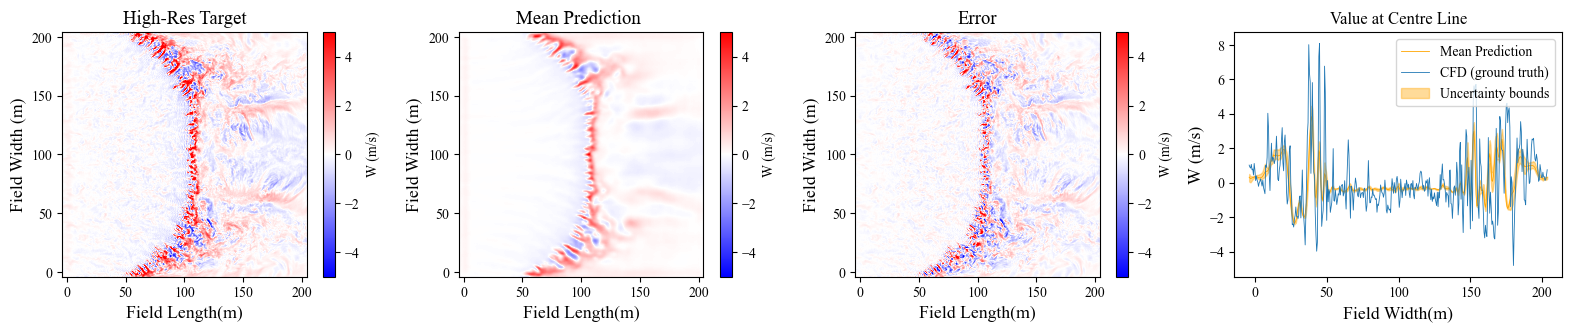

In [183]:
"""CALCULATE AND PLOT UNCERTAINTY INTERVALS"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Set up directories
noise_level=50
n=49

SR_estimated_directories = [
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/pb_49/X_test-50pnoise_0",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/pb_49/X_test-50pnoise_1",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/pb_49/X_test-50pnoise_2",
    "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_SR_estimations/pb_49/X_test-50pnoise_3"
]
terrain_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/X_test"
Target_directory="/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/Y_test"



n_target=16



def test_data_generator( n_target=n_target, high_altitude_directories=SR_estimated_directories, 
                            Target_directory=Target_directory,Input_directory=terrain_directory):
             
    reconstructed_batch=np.zeros([len(high_altitude_directories),4,416,416])
    terrain_batch=np.zeros([len(high_altitude_directories),4,416,416])
    target_batch=np.zeros([len(high_altitude_directories),3,416,416])
    for a in range(len(high_altitude_directories)):
            reconstructed_batch[a]    = np.array(np.load(f"{high_altitude_directories[a]}/{n_target}.npy")).reshape([4,416,416])
            terrain_batch[a] = np.array(np.load(f"{Input_directory}/{n_target}.npy"))[4:8] 
            target_batch[a]  = np.array(np.load(f"{Target_directory}/{n_target}.npy")) 

    reconstructed_batch[:, 3] = reconstructed_batch[:, 3] / 4  # Normalising T40
    #print(reconstructed_batch.shape)
    terrain_batch[:, 0] = terrain_batch[:, 0] / 1500
    terrain_batch[:, 1] = terrain_batch[:, 1] / 90
    terrain_batch[:, 2] = terrain_batch[:, 2] / 2

    input_batch=np.concatenate((reconstructed_batch,terrain_batch),axis=1)

    yield input_batch, target_batch 




# Generate data for both inputs
data_gen = test_data_generator(n_target=n_target)
input,target_batch = next(data_gen)
print(input.shape)
# Predict for current batch with training=True to enable dropout
predictions = model(input, training=True)
print(predictions.shape)
mean_predictions = np.mean(predictions, axis=0)
max_predictions = np.max(predictions, axis=0)*1.07
min_predictions = np.min(predictions, axis=0)*0.96
std_predictions=np.std(predictions,axis=0)
highres_image=np.load(f"{Target_directory}/{n_target}.npy")


feature=2
max_val=5
min_val=-5
fontsize = 15
plt.figure(figsize=(15.7, 3.1))
plt.subplot(1, 4, 1)

plt.title('High-Res Target',fontsize = 0.9*fontsize)
plt.xlabel('Field Length(m)',fontsize = 0.85*fontsize)
plt.ylabel('Field Width (m)',fontsize = 0.85*fontsize)
plt.imshow(highres_image[feature].T, cmap='bwr',vmin=min_val,vmax=max_val,extent=(-4, 204, -4, 204))
plt.colorbar(label="W (m/s)")

plt.subplot(1, 4, 2)
plt.title(f'Mean Prediction ',fontsize = 0.9*fontsize)
plt.imshow(mean_predictions[feature].T, cmap='bwr',vmin=min_val,vmax=max_val,extent=(-4, 204, -4, 204))
plt.xlabel('Field Length(m)',fontsize = 0.85*fontsize)
plt.ylabel('Field Width (m)',fontsize = 0.85*fontsize)
plt.colorbar(label="W (m/s)")

plt.subplot(1, 4, 3)
plt.title(f'Error',fontsize = 0.9*fontsize)
plt.imshow((highres_image[feature]-mean_predictions[feature]).T, cmap='bwr',vmin=-5,vmax=5,extent=(-4, 204, -4, 204))
plt.xlabel('Field Length(m)',fontsize = 0.85*fontsize)
plt.ylabel('Field Width (m)',fontsize = 0.85*fontsize)
plt.colorbar(label="W (m/s)")

plt.subplot(1, 4, 4)
plt.title(f'Value at Centre Line')
x=np.arange(416)
plt.plot((x/2)-4,mean_predictions[feature][208], label='Mean Prediction', color='orange',linewidth=0.6)
plt.plot((x/2)-4,highres_image[feature][208], label='CFD (ground truth)',linewidth=0.6)
plt.fill_between((x/2)-4,min_predictions[feature][208], max_predictions[feature][208], color='orange', alpha=0.4, label='Uncertainty bounds')
plt.xlabel('Field Width(m)',fontsize = 0.85*fontsize)
plt.ylabel('W (m/s)',fontsize = 0.85*fontsize)
plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout(pad=0)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig(f"/home/availab-dl1/Documents/sample{n_target}-N{n}(3)-W-noise{noise_level}.png",dpi=200)
plt.show()



